In [7]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import *
from keras.utils import np_utils

%matplotlib inline

In [8]:
cd d:\My Drive\Colab Notebooks\DAV Assessment\cefas_smartBuoy

d:\My Drive\Colab Notebooks\DAV Assessment\cefas_smartBuoy


In [9]:
df = pd.read_csv('clean_ext_data.csv', parse_dates = ['dateTime'])
df = df.set_index('dateTime')
df = df.drop('kd', axis = 1)
df = df.dropna()

phase_0 = df.loc[df['phase'] == 0, :].copy()
X = phase_0.drop(['fluors', 'phase'], axis = 1).copy()
y = phase_0['fluors'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# standardize the data
scaler = StandardScaler()
#train the scaler on the training data
X_train = scaler.fit_transform(X_train)
#apply the scaler to the test data sets
X_test = scaler.transform(X_test)
X = scaler.transform(X)

phase_1 = df.loc[df['phase'] > 0, :].copy()
X_1 = phase_1.drop(['fluors', 'phase'], axis = 1).copy()
y_1 = phase_1.loc[:, 'fluors'].copy()
scaler = StandardScaler()
X_1 = scaler.fit_transform(X_1)

In [16]:
model = keras.models.load_model('b2e20_1.h5')
dummy_regr = DummyRegressor(strategy = "mean")
dummy_regr.fit(X_train, y_train)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
poly_reg = PolynomialFeatures(degree = 3, include_bias = False)
X_poly = poly_reg.fit_transform(X_train)
poly_reg.fit(X_poly, y_train)
lin_reg2 = LinearRegression(fit_intercept = False)
lin_reg2.fit(X_poly, y_train)

pred_train = model.predict(X_train)
dummy_pred_train = dummy_regr.predict(X_train)
lin_pred_train = lin_reg.predict(X_train)
poly_pred_train = lin_reg2.predict(poly_reg.fit_transform(X_train))

pred_test = model.predict(X_test)
dummy_pred_test = dummy_regr.predict(X_test)
lin_pred_test = lin_reg.predict(X_test)
poly_pred_test = lin_reg2.predict(poly_reg.fit_transform(X_test))

fluors_pred = model.predict(X)
dummy_fluors_pred = dummy_regr.predict(X)
lin_fluors_pred = lin_reg.predict(X)
poly_fluors_pred = lin_reg2.predict(poly_reg.fit_transform(X))

fluors_pred_1 = model.predict(X_1)
dummy_fluors_pred_1 = dummy_regr.predict(X_1)
lin_fluors_pred_1 = lin_reg.predict(X_1)
poly_fluors_pred_1 = lin_reg2.predict(poly_reg.fit_transform(X_1))

phase_0.loc[:, 'fluors_pred'] = fluors_pred
phase_0.loc[:, 'dummy_fluors_pred'] = dummy_fluors_pred
phase_0.loc[:, 'lin_fluors_pred'] = lin_fluors_pred
phase_0.loc[:, 'poly_fluors_pred'] = poly_fluors_pred
phase_1.loc[:, 'fluors_pred'] = fluors_pred_1
phase_1.loc[:, 'dummy_fluors_pred'] = dummy_fluors_pred_1
phase_1.loc[:, 'lin_fluors_pred'] = lin_fluors_pred_1
phase_1.loc[:, 'poly_fluors_pred'] = poly_fluors_pred_1

1904/1904 [==============================] - 10s 5ms/step


C:\Users\709583\AppData\Local\Temp\ipykernel_8100\1688749845.py:32: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  phase_0.loc[:, 'fluors_pred'] = fluors_pred
C:\Users\709583\AppData\Local\Temp\ipykernel_8100\1688749845.py:36: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  phase_1.loc[:, 'fluors_pred'] = fluors_pred_1


In [17]:
print(f'Training RMS error: {np.sqrt(mean_squared_error(y_train, pred_train))}')
print(f'Dummy Training RMS error: {np.sqrt(mean_squared_error(y_train, dummy_pred_train))}')
print(f'Linear Training RMS error: {np.sqrt(mean_squared_error(y_train, lin_pred_train))}')
print(f'Polynomial Training RMS error: {np.sqrt(mean_squared_error(y_train, poly_pred_train))}')
print('')
print(f'Training r2 score: {r2_score(y_train, pred_train)}')
print(f'Dummy Training r2 score: {r2_score(y_train, dummy_pred_train)}')
print(f'Linear Training r2 score: {r2_score(y_train, lin_pred_train)}')
print(f'Polynomial Training r2 score: {r2_score(y_train, poly_pred_train)}')
print('')
print(f'Training MEA error: {median_absolute_error(y_train, pred_train)}')
print(f'Dummy Training MEA error: {median_absolute_error(y_train, dummy_pred_train)}')
print(f'Linear Training MEA error: {median_absolute_error(y_train, lin_pred_train)}')
print(f'Polynomial Training MEA error: {median_absolute_error(y_train, poly_pred_train)}')

Training RMS error: 1.1962141277229947
Dummy Training RMS error: 1.9010678603688378
Linear Training RMS error: 1.7836886216542496
Polynomial Training RMS error: 1.6759814680017109

Training r2 score: 0.6040661661824841
Dummy Training r2 score: 0.0
Linear Training r2 score: 0.11967538702173641
Polynomial Training r2 score: 0.22278140076714514

Training MEA error: 0.21218995094299262
Dummy Training MEA error: 0.6287229497490803
Linear Training MEA error: 0.4869508940038564
Polynomial Training MEA error: 0.47944827245431804


In [18]:
print(f'Test RMS error: {np.sqrt(mean_squared_error(y_test, pred_test))}')
print(f'Dummy Test RMS error: {np.sqrt(mean_squared_error(y_test, dummy_pred_test))}')
print(f'Linear Test RMS error: {np.sqrt(mean_squared_error(y_test, lin_pred_test))}')
print(f'Polynomial Test RMS error: {np.sqrt(mean_squared_error(y_test, poly_pred_test))}')
print('')
print(f'Test r2 score: {r2_score(y_test, pred_test)}')
print(f'Dummy Test r2 score: {r2_score(y_test, dummy_pred_test)}')
print(f'Linear Test r2 score: {r2_score(y_test, lin_pred_test)}')
print(f'Polynomial Test r2 score: {r2_score(y_test, poly_pred_test)}')
print('')
print(f'Test MEA error: {median_absolute_error(y_test, pred_test)}')
print(f'Dummy Test MEA error: {median_absolute_error(y_test, dummy_pred_test)}')
print(f'Linear Test MEA error: {median_absolute_error(y_test, lin_pred_test)}')
print(f'Polynomial Test MEA error: {median_absolute_error(y_test, poly_pred_test)}')

Test RMS error: 1.1832522740351987
Dummy Test RMS error: 1.8647719433365813
Linear Test RMS error: 1.7597248501738163
Polynomial Test RMS error: 1.675423571914482

Test r2 score: 0.5973430019141175
Dummy Test r2 score: -7.370503184223054e-05
Linear Test r2 score: 0.10942584006411604
Polynomial Test r2 score: 0.192709580516902

Test MEA error: 0.21248807907104472
Dummy Test MEA error: 0.6237229497490804
Linear Test MEA error: 0.4836435826105044
Polynomial Test MEA error: 0.4910986130091911


In [19]:
print(f'Overall pre-construcion RMS error: {np.sqrt(mean_squared_error(y, fluors_pred))}')
print(f'Dummy Overall pre-construcion RMS error: {np.sqrt(mean_squared_error(y, dummy_fluors_pred))}')
print(f'Linear Overall pre-construcion RMS error: {np.sqrt(mean_squared_error(y, lin_fluors_pred))}')
print(f'Polynomial Overall pre-construcion RMS error: {np.sqrt(mean_squared_error(y, poly_fluors_pred))}')
print('')
print(f'Overall pre-construcion r2 score: {r2_score(y, fluors_pred)}')
print(f'Dummy Overall pre-construcion r2 score: {r2_score(y, dummy_fluors_pred)}')
print(f'Linear Overall pre-construcion r2 score: {r2_score(y, lin_fluors_pred)}')
print(f'Polynomial Overall pre-construcion r2 score: {r2_score(y, poly_fluors_pred)}')
print('')
print(f'Overall pre-construcion MEA error: {median_absolute_error(y, fluors_pred)}')
print(f'Dummy Overall pre-construcion MEA error: {median_absolute_error(y, dummy_fluors_pred)}')
print(f'Linear Overall pre-construcion MEA error: {median_absolute_error(y, lin_fluors_pred)}')
print(f'Polynomial Overall pre-construcion MEA error: {median_absolute_error(y, poly_fluors_pred)}')

Overall pre-construcion RMS error: 1.1923402774378171
Dummy Overall pre-construcion RMS error: 1.8902520130141895
Linear Overall pre-construcion RMS error: 1.7765332648057681
Polynomial Overall pre-construcion RMS error: 1.6758141147822883

Overall pre-construcion r2 score: 0.6021092759261594
Dummy Overall pre-construcion r2 score: -6.4556903487389405e-06
Linear Overall pre-construcion r2 score: 0.11669625256705196
Polynomial Overall pre-construcion r2 score: 0.21401352445355892

Overall pre-construcion MEA error: 0.21226980686187746
Dummy Overall pre-construcion MEA error: 0.6287229497490796
Linear Overall pre-construcion MEA error: 0.4858885057074884
Polynomial Overall pre-construcion MEA error: 0.4827890822983881


In [22]:
print(f'Overall post-construction RMS error {np.sqrt(mean_squared_error(y_1, fluors_pred_1))}')
print(f'Dummy Overall post-construction RMS error {np.sqrt(mean_squared_error(y_1, dummy_fluors_pred_1))}')
print(f'Linear Overall post-construction RMS error {np.sqrt(mean_squared_error(y_1, lin_fluors_pred_1))}')
print(f'Polynomial Overall post-construction RMS error {np.sqrt(mean_squared_error(y_1, poly_fluors_pred_1))}')
print('')
print(f'Overall post-construction r2 score {r2_score(y_1, fluors_pred_1)}')
print(f'Dummy Overall post-construction r2 score {r2_score(y_1, dummy_fluors_pred_1)}')
print(f'Linear Overall post-construction r2 score {r2_score(y_1, lin_fluors_pred_1)}')
print(f'Polynomial Overall post-construction r2 score {r2_score(y_1, poly_fluors_pred_1)}')
print('')
print(f'Overall post-construction MEA error {median_absolute_error(y_1, fluors_pred_1)}')
print(f'Dummy Overall post-construction MEA error {median_absolute_error(y_1, dummy_fluors_pred_1)}')
print(f'Linear Overall post-construction MEA error {median_absolute_error(y_1, lin_fluors_pred_1)}')
print(f'Polynomial Overall post-construction MEA error {median_absolute_error(y_1, poly_fluors_pred_1)}')

Overall post-construction RMS error 1.413517008493437
Dummy Overall post-construction RMS error 1.307951947747019
Linear Overall post-construction RMS error 1.2580687885486317
Polynomial Overall post-construction RMS error 1.3910657637200765

Overall post-construction r2 score -0.2082184373000675
Dummy Overall post-construction r2 score -0.034491578093298836
Linear Overall post-construction r2 score 0.04291136845096544
Polynomial Overall post-construction r2 score -0.1701423715373791

Overall post-construction MEA error 0.3174171304702753
Dummy Overall post-construction MEA error 0.6637229497490804
Linear Overall post-construction MEA error 0.5412200849971343
Polynomial Overall post-construction MEA error 0.5442134663431348


C:\Users\709583\AppData\Local\Temp\ipykernel_8100\2422744035.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


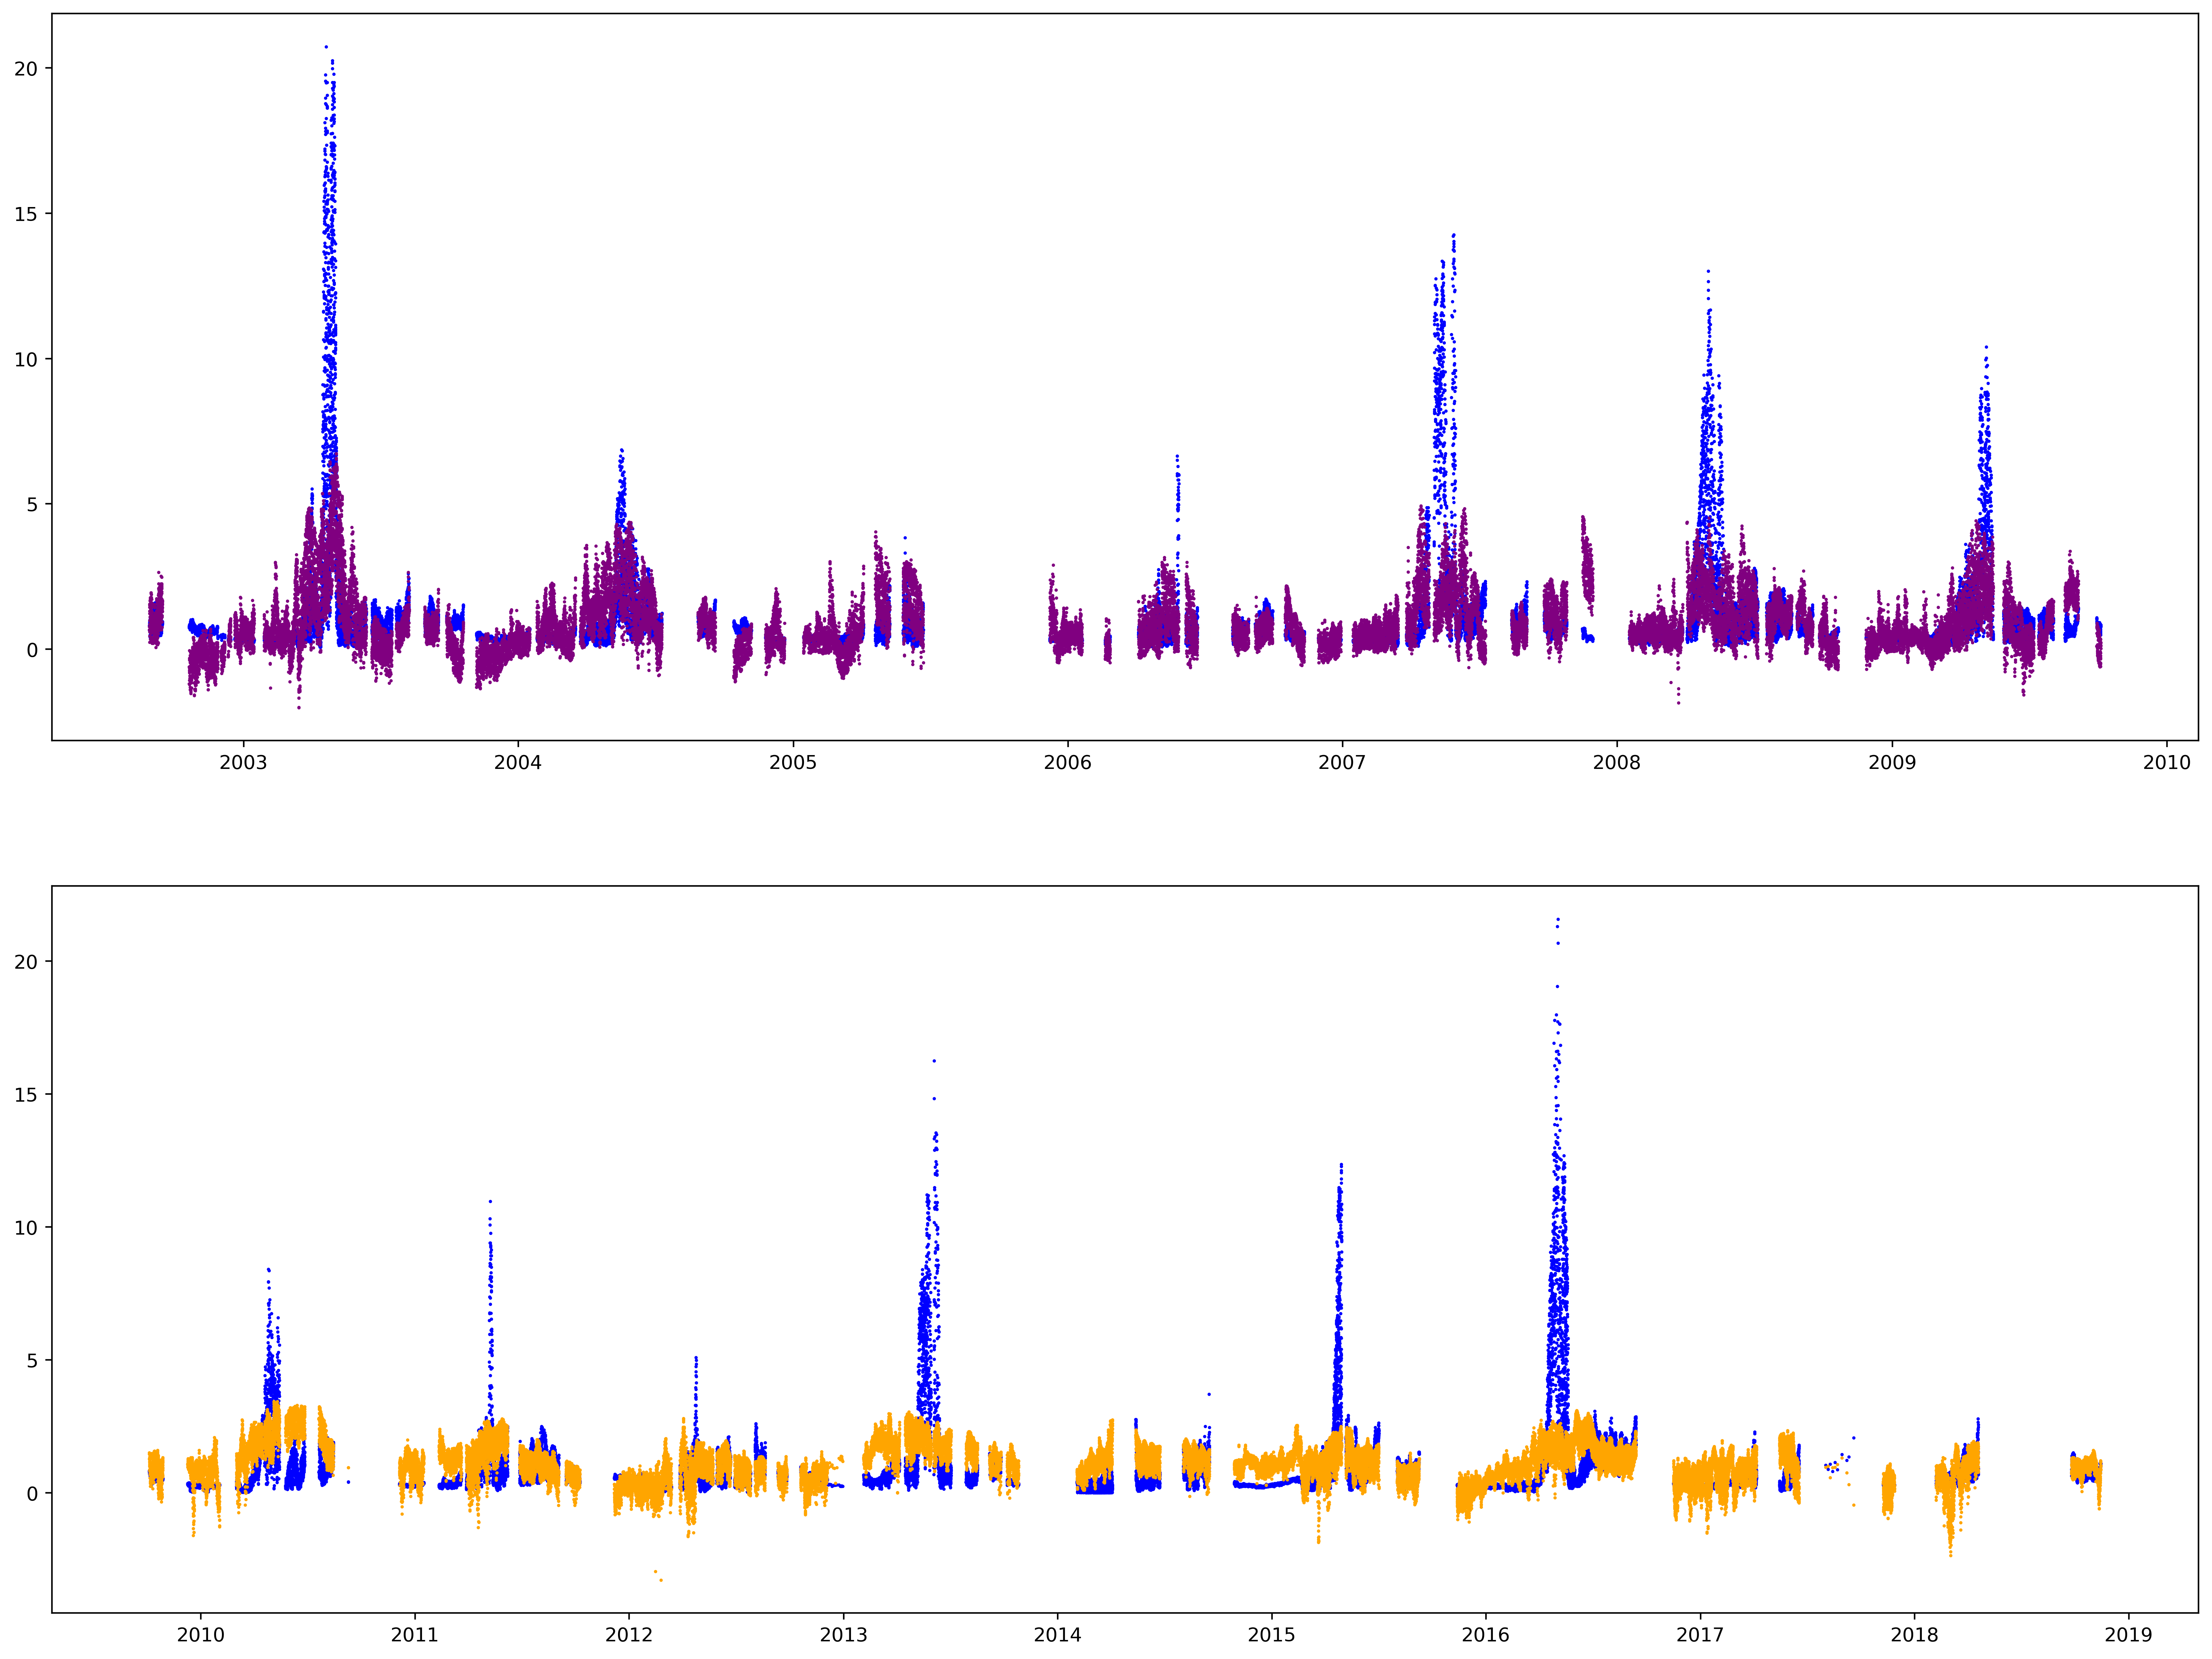

In [29]:
fig, ax = plt.subplots(2,1, figsize = (20, 15), dpi = 400)
ax[0].scatter(phase_0.index, phase_0['fluors'], s = 0.5, color = 'blue')
#ax[0].scatter(phase_0.index, phase_0['fluors_pred'], s = 0.5, color = 'red', alpha = 0.6)
#ax[0].scatter(phase_0.index, phase_0['lin_fluors_pred'], s = 0.5, color = 'orange')
ax[0].scatter(phase_0.index, phase_0['poly_fluors_pred'], s = 0.5, color = 'purple')
#ax[0].scatter(phase_0.index, phase_0['dummy_fluors_pred'], s = 0.5, color = 'green')
ax[1].scatter(phase_1.index, phase_1['fluors'], s = 0.5, color = 'blue')
#ax[1].scatter(phase_1.index, phase_1['fluors_pred'], s = 0.5, color = 'red', alpha = 0.6)
ax[1].scatter(phase_1.index, phase_1['lin_fluors_pred'], s = 0.5, color = 'orange')
#ax[1].scatter(phase_1.index, phase_1['poly_fluors_pred'], s = 0.5, color = 'purple')
#ax[1].scatter(phase_1.index, phase_1['dummy_fluors_pred'], s = 0.5, color = 'green')
#fig.savefig('model_predictions.png', dpi = 400)
fig.show()